# **Необходимые для работы библиотеки**

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import time
from torch import nn, optim
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

Device available:  cuda


# **Загрузка Датасета**

In [ ]:
train_data = []
with open('/content/drugsComTrain_raw.csv', 'r', encoding='utf-8', errors='ignore') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        train_data.append(row)

train_df = pd.DataFrame(train_data[1:], columns=train_data[0])

test_data = []
with open('/content/drugsComTest_raw.csv', 'r', encoding='utf-8', errors='ignore') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        test_data.append(row)

test_df = pd.DataFrame(test_data[1:], columns=test_data[0])

In [ ]:
train_df['rating'] = train_df['rating'].astype(float)
test_df['rating'] = test_df['rating'].astype(float)

In [ ]:
print(train_df['rating'].dtypes)
print(test_df['rating'].dtypes)

float64
float64


In [ ]:
print(train_df.head())

  uniqueID                  drugName                     condition  \
0   206461                 Valsartan  Left Ventricular Dysfunction   
1    95260                Guanfacine                          ADHD   
2    92703                    Lybrel                 Birth Control   
3   138000                Ortho Evra                 Birth Control   
4    35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...     9.0  20-May-12   
1  "My son is halfway through his fourth week of ...     8.0  27-Apr-10   
2  "I used to take another oral contraceptive, wh...     5.0  14-Dec-09   
3  "This is my first time using any form of birth...     8.0   3-Nov-15   
4  "Suboxone has completely turned my life around...     9.0  27-Nov-16   

  usefulCount  
0          27  
1         192  
2          17  
3          10  
4          37  


In [ ]:
print(test_df.head())

  uniqueID         drugName                     condition  \
0   163740      Mirtazapine                    Depression   
1   206473       Mesalamine  Crohn's Disease, Maintenance   
2   159672          Bactrim       Urinary Tract Infection   
3    39293         Contrave                   Weight Loss   
4    97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried a few antidepressants over th...    10.0  28-Feb-12   
1  "My son has Crohn&#039;s disease and has done ...     8.0  17-May-09   
2                      "Quick reduction of symptoms"     9.0  29-Sep-17   
3  "Contrave combines drugs that were used for al...     9.0   5-Mar-17   
4  "I have been on this birth control for one cyc...     9.0  22-Oct-15   

  usefulCount  
0          22  
1          17  
2           3  
3          35  
4           4  


In [ ]:
train_df.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [ ]:
train_df.shape

(161297, 7)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   uniqueID     161297 non-null  object 
 1   drugName     161297 non-null  object 
 2   condition    161297 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  object 
dtypes: float64(1), object(6)
memory usage: 8.6+ MB


In [ ]:
train_df['condition'].value_counts()

condition
Birth Control                                              28788
Depression                                                  9069
Pain                                                        6145
Anxiety                                                     5904
Acne                                                        5588
                                                           ...  
Dissociative Identity Disorde                                  1
Hydrocephalus                                                  1
Hyperlipoproteinemia Type III, Elevated beta-VLDL   IDL        1
Q Feve                                                         1
Neutropenia                                                    1
Name: count, Length: 885, dtype: int64

# **Предобработка данных**

Проведем очистку данных перед обучением модели:
- приведем текст к нижнему регистру
- удалим короткие слова (длиной 1-2 буквы)
- удалим числа
- удалим пунктуацию
- удалим стоп-слова (английские, так как датасет английский)

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train_df['cleaned_review'] = train_df['review'].apply(clean_text)
test_df['cleaned_review'] = test_df['review'].apply(clean_text)

print(train_df[['review', 'cleaned_review']].head())
print(test_df[['review', 'cleaned_review']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                              review  \
0  "It has no side effect, I take it in combinati...   
1  "My son is halfway through his fourth week of ...   
2  "I used to take another oral contraceptive, wh...   
3  "This is my first time using any form of birth...   
4  "Suboxone has completely turned my life around...   

                                      cleaned_review  
0     side effect take combination bystolic fish oil  
1  son halfway fourth week intuniv became concern...  
2  used take another oral contraceptive pill cycl...  
3  first time using form birth control glad went ...  
4  suboxone completely turned life around feel he...  
                                              review  \
0  "I&#039;ve tried a few antidepressants over th...   
1  "My son has Crohn&#039;s disease and has done ...   
2                      "Quick reduction of symptoms"   
3  "Contrave combines drugs that were used for al...   
4  "I have been on this birth control for one cyc... 

# **Визуализация**

Визуализируем некоторую информацию о данных датасета:
- Топ 20 условий для выдачи лекарства
- Гистограмму рейтинга лекартсв
- Названия самых популярных лекарств

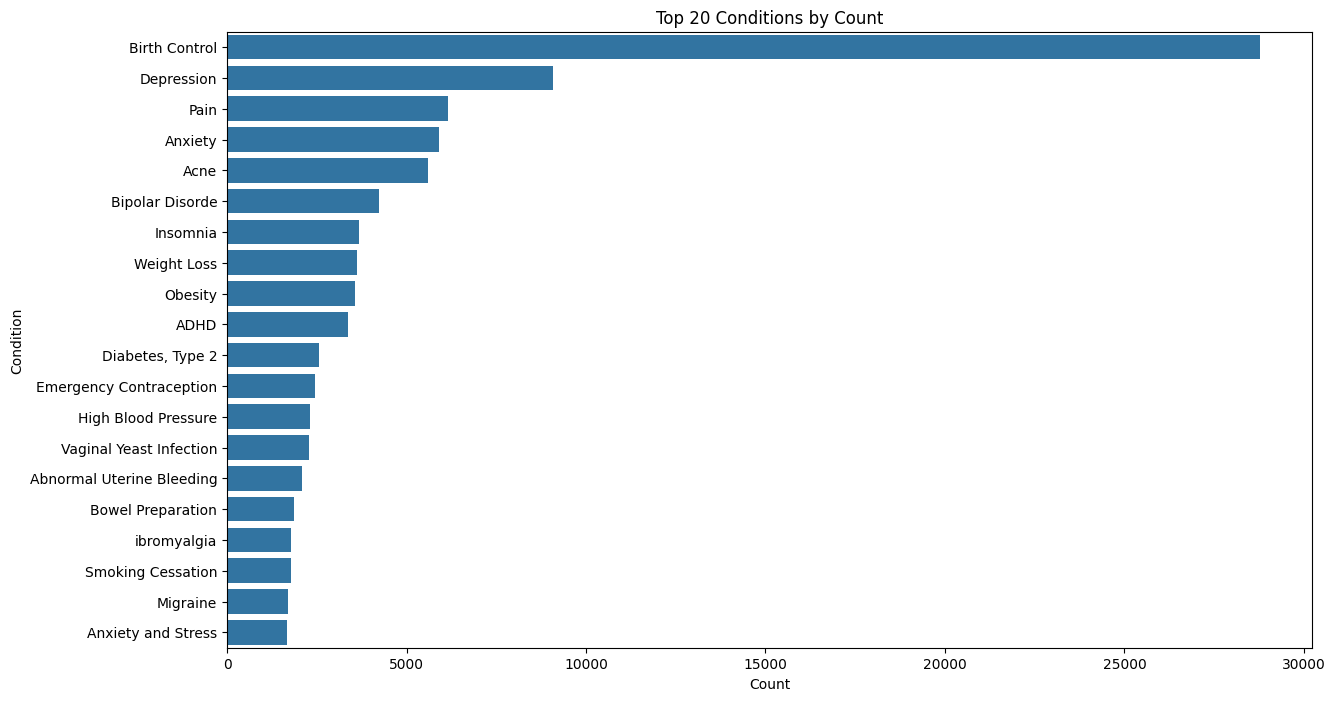

In [ ]:
plt.figure(figsize=(14,8))
sns.countplot(data=train_df, y='condition', order=train_df['condition'].value_counts().index[:20])
plt.title('Top 20 Conditions by Count')
plt.xlabel('Count')
plt.ylabel('Condition')
plt.show()

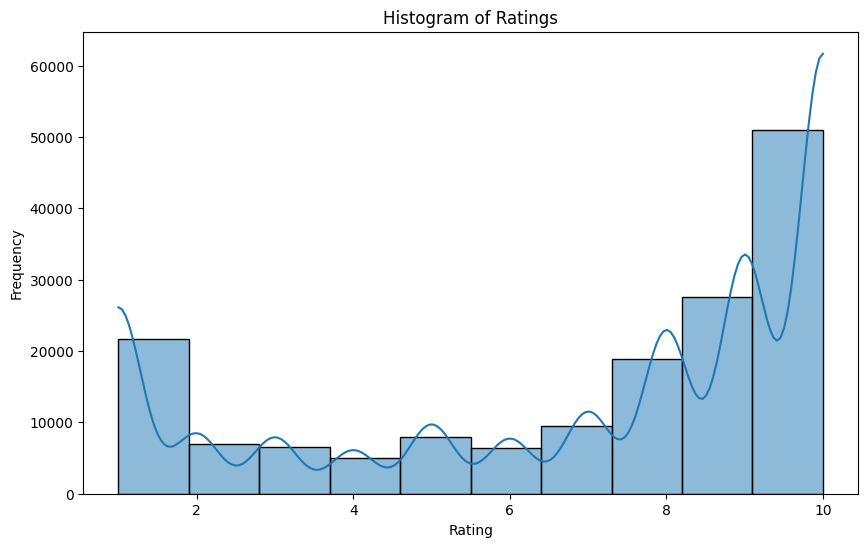

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x='rating', bins=10, kde=True)
plt.title('Histogram of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

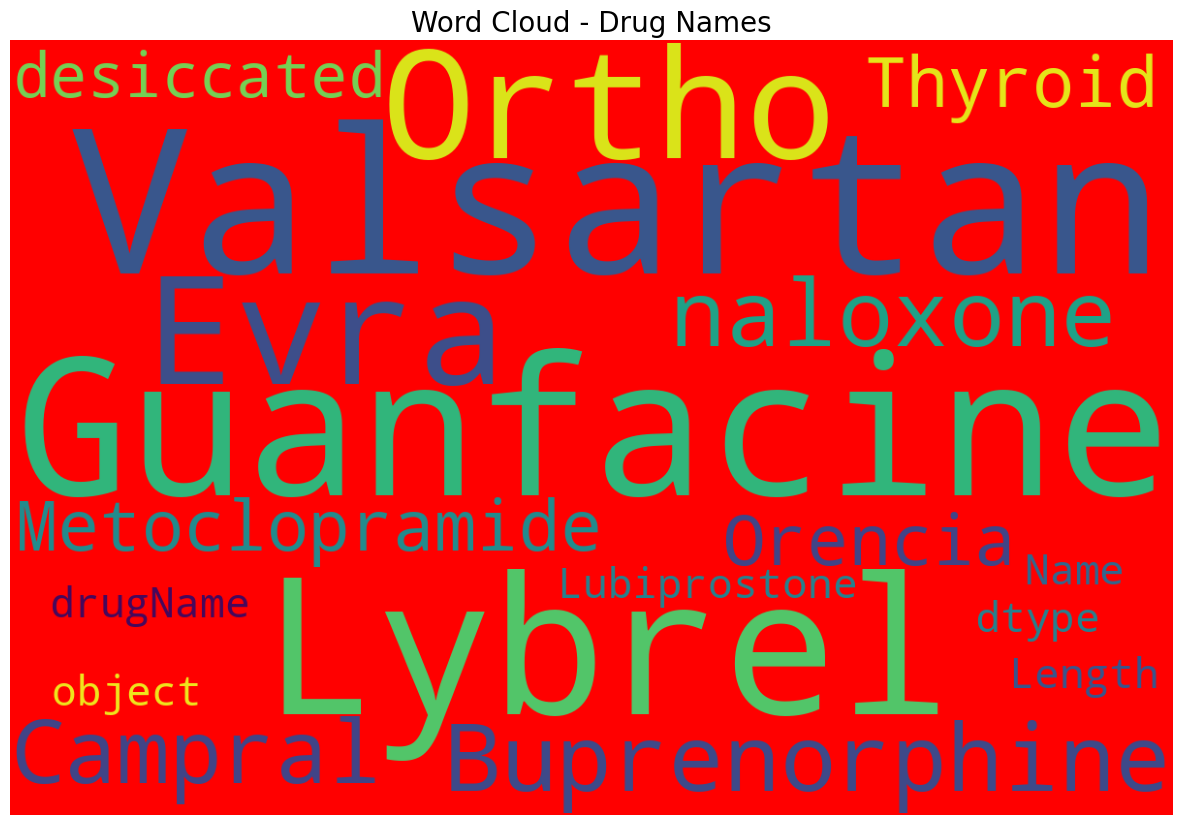

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'red', stopwords = stopwords, width = 1200, height = 800).generate(str(train_df['drugName']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud - Drug Names', fontsize = 20)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# **Прогнозирование рейтинга на основе текста отзыва**

Для этой задачи я решил использовать трансформер BERT.
Выполнение задачи по шагам:
- Разделим данные на тренировочную и тестовую выборки
- Используем подвыборку данных для более быстрой проверки кода (я решил уменьшить выборку, так как на полной выборке у меня модель обучалась очень много времени)
- Загрузим предобученный токенизатор BERT который разобьет текст на токены для BERT, создадим маски внимания и сегментные идентификаторы
- Создаим класс для создания Датасета который потом подадим в Dataloader
- Создадим Dataset и Dataloader для Train и Val
- Проверим элементы созданного и загруженного датасета
- Загрузим модель
- В качестве оптимизатора будем использовать Adam
- Определим функцию потерь
- Определим функцию для тренировки модели
- Определим функцию для оценки модели
- Запустим модель на обучение

Сам процесс обучения по 10 эпохам занял около 25 минут.
В результате обучения после 10 эпох удалось достиь accuracy = 0.87 что в принципе считаю неплохим результатом.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_df['cleaned_review'], train_df['rating'], test_size=0.1, random_state=42)

In [ ]:
X_train = X_train[:5000]
y_train = y_train[:5000]
X_val = X_val[:1000]
y_val = y_val[:1000]

In [ ]:
print("Размер тренировочной выборки:", len(X_train))
print("Размер валидационной выборки:", len(X_val))

Размер тренировочной выборки: 5000
Размер валидационной выборки: 1000


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, ratings, tokenizer, max_len):
        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        rating = self.ratings[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'rating': torch.tensor(rating, dtype=torch.float)
        }

In [ ]:
train_dataset = ReviewsDataset(reviews=X_train.to_numpy(), ratings=y_train.to_numpy(), tokenizer=tokenizer, max_len=160)
val_dataset = ReviewsDataset(reviews=X_val.to_numpy(), ratings=y_val.to_numpy(), tokenizer=tokenizer, max_len=160)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
for data in train_loader:
    print(data)
    break

{'review_text': ['worked great depression low dose many years started high dose made anxious unfortunately paxil years lost effectiveness within week still found replacement', 'took help sleep brain surgery stop seizures others side effect possibly causing seizure took one one bad side effect alone depressed made depression worse take depressed glad son phoned', 'generic brand walmart much cheaper products worked better name brand gas', 'though never clinically depressed discovered powerful side effect tramadol taking day chronic sciatica unrelenting pain real downer tramadol reliably helped maintain optimistic upbeat attitude five years taking never increase dosage desired effect downside often interfered sleep found midday nap essential', 'excellent results cymbalta mg night burning pain reduced generate dreams uncomfortable dreams first medicine helped side effects great neurontin felt little effect lyrica', 'zestril originally since reduced mg past years pressure stabilised years l

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
loss_fn = nn.MSELoss().to(device)

In [ ]:
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        ratings = d["rating"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = loss_fn(outputs.logits.squeeze(), ratings)
        correct_predictions += torch.sum(torch.abs(outputs.logits.squeeze() - ratings) < 1).item()
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            ratings = d["rating"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = loss_fn(outputs.logits.squeeze(), ratings)
            correct_predictions += torch.sum(torch.abs(outputs.logits.squeeze() - ratings) < 1).item()
            losses.append(loss.item())

    return correct_predictions / n_examples, np.mean(losses)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        scheduler=None,
        n_examples=len(X_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        device,
        n_examples=len(X_val)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')

Epoch 1/10
----------
Train loss 10.470682071801573 accuracy 0.1848
Val loss 8.125630957739693 accuracy 0.255
Epoch 2/10
----------
Train loss 5.992954410303134 accuracy 0.3354
Val loss 7.700351597770812 accuracy 0.34
Epoch 3/10
----------
Train loss 4.244323775410272 accuracy 0.4572
Val loss 7.779035530393085 accuracy 0.436
Epoch 4/10
----------
Train loss 2.975202125482285 accuracy 0.56
Val loss 7.440749079462082 accuracy 0.475
Epoch 5/10
----------
Train loss 2.151274811155118 accuracy 0.6198
Val loss 7.809337886552962 accuracy 0.489
Epoch 6/10
----------
Train loss 1.5911435863842218 accuracy 0.6834
Val loss 7.9373312791188555 accuracy 0.505
Epoch 7/10
----------
Train loss 1.2211042804935108 accuracy 0.7424
Val loss 7.350278222371662 accuracy 0.47
Epoch 8/10
----------
Train loss 1.024901831016754 accuracy 0.777
Val loss 7.517653228744628 accuracy 0.499
Epoch 9/10
----------
Train loss 0.8294546997870881 accuracy 0.8048
Val loss 8.418040400459653 accuracy 0.535
Epoch 10/10
-------

# **Тематическое моделирование и кластеризация текстов**

Выполним тематическое моделирование и кластеризацию текстов из датасета с использованием LDA и KMeans:
- Загрузим необходимые библиотеки
- Преобразуем текст в TF-IDF представление
- Моделирование с помощью LDA
- Преобразовуем TF-IDF матрицы в тематические распределения
- Кластеризуем документы на основе тематических распределений
- Выведем ключевые слова для каждой из тем, выделенных моделью LDA
- Выведем примеры документов для каждого из кластеров: первые 200 символов из случайно выбранных 5 документов для каждого кластера.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(train_df['cleaned_review'])

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tfidf)

lda_features = lda.transform(tfidf)
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(lda_features)

train_df['cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

n_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
skin acne face using product use clear dry used cream
Topic #1:
pain works years great medicine relief effects mg day worked
Topic #2:
good seizures seizure keppra years excellent effects medicine treatment liver
Topic #3:
day smoking chantix burning itching quit took yeast smoke days
Topic #4:
anxiety life depression panic years attacks feel lexapro effects mg
Topic #5:
lbs weight lost blood pounds started effects pressure taking week
Topic #6:
years life drug insurance migraines suboxone medication day migraine taking
Topic #7:
sleep mg anxiety feel taking day night depression effects like
Topic #8:
pain day took days stomach taking infection hours diarrhea nausea
Topic #9:
period pill birth control months periods bleeding month weight got



In [ ]:
for cluster in range(10):
    print(f"Cluster {cluster}:")
    cluster_docs = train_df[train_df['cluster'] == cluster]['cleaned_review'].sample(5)
    for doc in cluster_docs:
        print(f"- {doc[:200]}...")
    print()

Cluster 0:
- journey started around yrs ago pregnant suffered episode put hospital son due gave mg straight clomipramine imagine comatosed next years many crashes drug years ago prescribed paxil best thing could e...
- research taking consult doctor also aware side effects involved symptoms include dizziness fatigue muscle weakness slowed speech muscle spasms twitching fidgeting nightmares everyone...
- started capsule oct th weight days phentermine lbs pill works immediately first day felt energy without feeling jittery took take later keep night take early typically fine feel little wired bed take ...
- diagnosed bipolar manifestations depression mostly problems mania started mg night week went morning night doses mg days day time doses made feel restless uncomfortable edgy weird sedated stand would ...
- tried lot different medications anxiety nothing ever worked prescribed atarax going stressful times something nothing ever helped paxil lexapro effexor zoloft know lot different one

# **Дистилляция трансформера в LSTM**

Для дистилляции трансформера в LSTM потребуется создать более простую модель и обучить её на предсказаниях сложной модели:
- Определим класс LSTMModel
- Определеним параметров модели и процесса обучения
- Созданим экземпляр модели
- Определим функцию потерь и оптимизатора
- Определим функцию для создания пакетов данных
- Определим функцию для обучения модели
- Подготовка данных для модели
- Непосрественно само обучение модели

С этим разделом задачи я до конца не разобрался - прошу по возможности (при условии что все остальное выполнено верно) зачесть ДЗ без него.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
input_dim = 768
hidden_dim = 128
output_dim = 1
n_layers = 2

In [ ]:
lstm_model = LSTMModel(input_dim, hidden_dim, output_dim, n_layers)
lstm_model = lstm_model.to(device)

In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [ ]:
def create_batches(data, batch_size):
    batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        inputs, targets = zip(*batch)

        inputs = np.array([np.array(inp) for inp in inputs])
        targets = np.array(targets)

        print(f"Batch {i//batch_size + 1}:")
        print(f"inputs shape after conversion: {inputs.shape}")
        print(f"targets shape after conversion: {targets.shape}")

        inputs = torch.tensor(inputs).float()
        targets = torch.tensor(targets).float()

        batches.append((inputs, targets))
    return batches

In [ ]:
def train_lstm_model(model, train_data, val_data, criterion, optimizer, num_epochs=10, batch_size=32):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        train_batches = create_batches(train_data, batch_size)

        for inputs, targets in train_batches:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        val_batches = create_batches(val_data, batch_size)
        with torch.no_grad():
            for inputs, targets in val_batches:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))

                val_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_batches):.4f}, Val Loss: {val_loss / len(val_batches):.4f}")


In [ ]:
train_lstm_data = prepare_lstm_data(train_loader, model, device)
val_lstm_data = prepare_lstm_data(val_loader, model, device)

In [ ]:
train_lstm_model(lstm_model, train_lstm_data, val_lstm_data, criterion, optimizer, num_epochs=10)

Batch 1:
inputs shape after conversion: (32, 16, 1)
targets shape after conversion: (32, 16)
Batch 2:
inputs shape after conversion: (32, 16, 1)
targets shape after conversion: (32, 16)
Batch 3:
inputs shape after conversion: (32, 16, 1)
targets shape after conversion: (32, 16)
Batch 4:
inputs shape after conversion: (32, 16, 1)
targets shape after conversion: (32, 16)
Batch 5:
inputs shape after conversion: (32, 16, 1)
targets shape after conversion: (32, 16)
Batch 6:
inputs shape after conversion: (32, 16, 1)
targets shape after conversion: (32, 16)
Batch 7:
inputs shape after conversion: (32, 16, 1)
targets shape after conversion: (32, 16)
Batch 8:
inputs shape after conversion: (32, 16, 1)
targets shape after conversion: (32, 16)
Batch 9:
inputs shape after conversion: (32, 16, 1)
targets shape after conversion: (32, 16)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (25,) + inhomogeneous part.

Так и не смог разобраься в чем ошибка при обучении - понимаю что скорее всего при определении размерности выходных данных, но в чем именно и как исправить пока не могу определить.

**С этим разделом задачи я до конца не разобрался - прошу по возможности (при условии что все остальное выполнено верно) зачесть ДЗ без него.**